In [ ]:
import pandas as pd
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt
from scipy import ndimage
import urllib.request
from skimage.io import imread,imshow
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.transform import resize
from skimage.feature import hog
from PIL import Image, ImageDraw
import xml.etree.ElementTree as ET
from sklearn.metrics import jaccard_score
from scipy.spatial import distance
from copy import deepcopy

Original Images


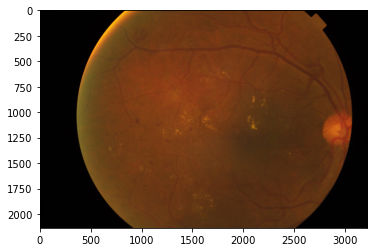

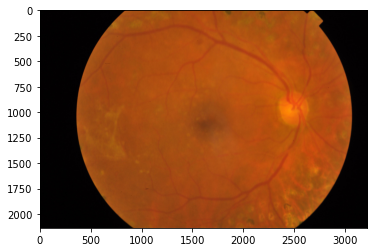

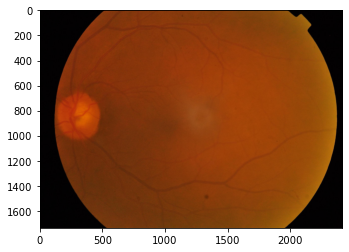

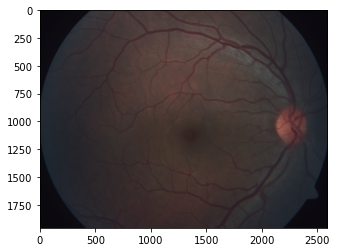

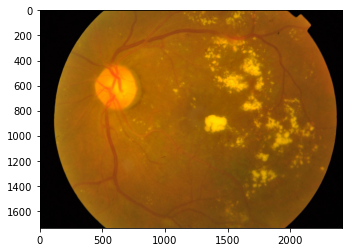

In [ ]:
data = "D:/APTOS/SAMPLE" 
path = os.path.join(data) 
print("Original Images")
for img in os.listdir(path):
    img_array = imread(os.path.join(path,img)) 
    plt.imshow(img_array) 
    plt.show()

In [ ]:
def single_dice_coef(y_true, y_pred_bin):
    # shape of y_true and y_pred_bin: (height, width)
    intersection = np.sum(y_true * y_pred_bin)
    if (np.sum(y_true)==0) and (np.sum(y_pred_bin)==0):
        return 1
    print("Dice Coeffient",(2*intersection) / (np.sum(y_true) + np.sum(y_pred_bin)))

def jaccard(target, prediction):
    intersection = np.logical_and(target, prediction)
    union = np.logical_or(target, prediction)
    iou_score = np.sum(intersection) / np.sum(union)
    print("Jaccard",iou_score)

Dice Coeffient 1.7281096411643933
Jaccard 0.6696382611753964
Dice Coeffient 1.8325019376129768
Jaccard 0.7200847646132633
Dice Coeffient 1.8584147097124861
Jaccard 0.8108996856593524
Dice Coeffient 1.2572110861962522
Jaccard 0.4596850711936762
Dice Coeffient 1.0225021137980637
Jaccard 0.31106658375804924


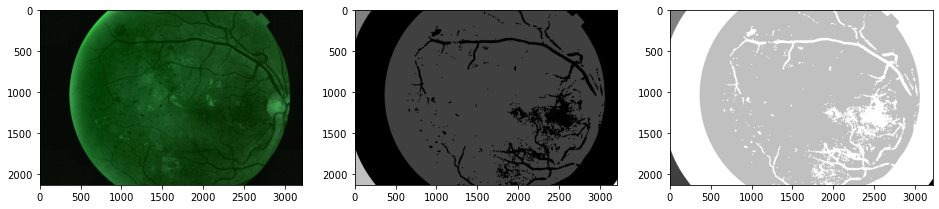

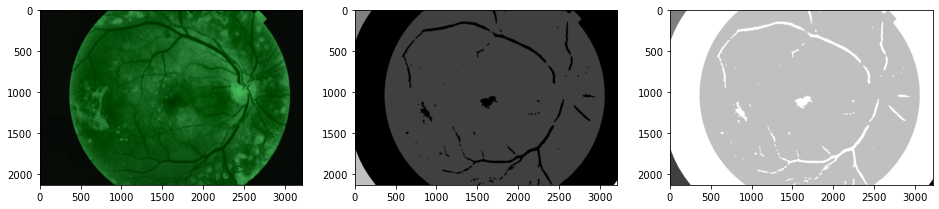

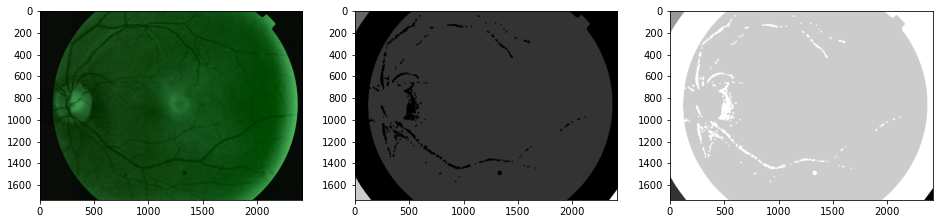

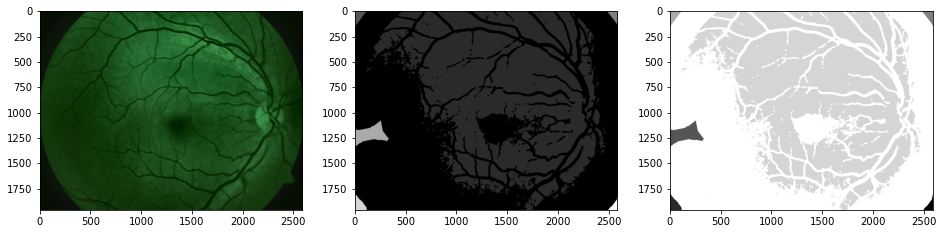

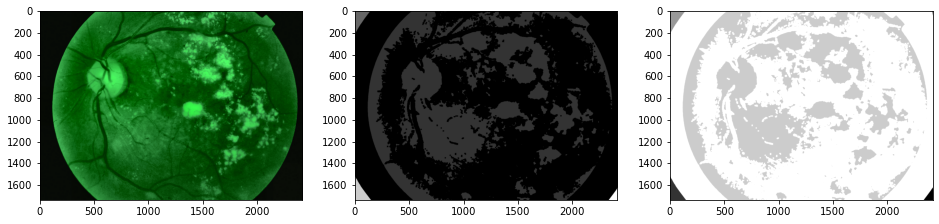

In [ ]:
def watershed():
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        
        new_path = os.path.join(path, img_array)
        image_original = imread(new_path)
        green_channel=deepcopy(image_original)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
    
        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        
        gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

        # noise removal
        kernel = np.ones((3,3),np.uint8)
        opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

        # sure background area
        sure_bg = cv2.dilate(opening,kernel,iterations=3)

        # Finding sure foreground area
        dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
        ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

        # Finding unknown region
        sure_fg = np.uint8(sure_fg)
        unknown = cv2.subtract(sure_bg,sure_fg)
    
        # Marker labelling
        ret, markers = cv2.connectedComponents(sure_fg)

        # Add one to all labels so that sure background is not 0, but 1
        markers = markers+1

        # Now, mark the region of unknown with zero
        markers[unknown==255] = 0
        img_neg = 1 - markers
        
        plt.figure(figsize=(16,12))
        plt.subplot(131).imshow(image)
        plt.subplot(132).imshow(markers,cmap="gray")
        plt.subplot(133).imshow(img_neg,cmap="gray")
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        single_dice_coef(img,markers)
        jaccard(img,markers)
watershed()        

# CANNY EDGE DETECTION

Dice Coeffient 0.013135603721704725
Jaccard 0.005210953658672928
Dice Coeffient 0.009975714855556159
Jaccard 0.0036026561946820206
Dice Coeffient 0.01612171662681312
Jaccard 0.007526865825373089
Dice Coeffient 0.019987408262819792
Jaccard 0.008970647902711185
Dice Coeffient 0.0857464283843686
Jaccard 0.0331869716483047


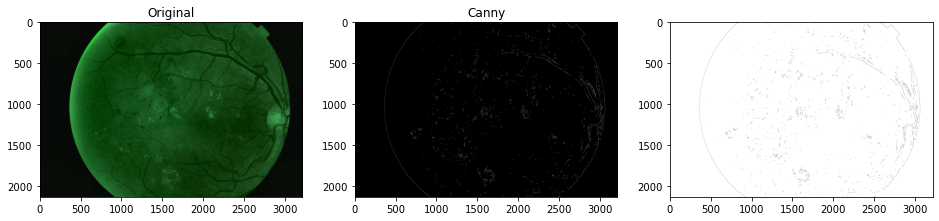

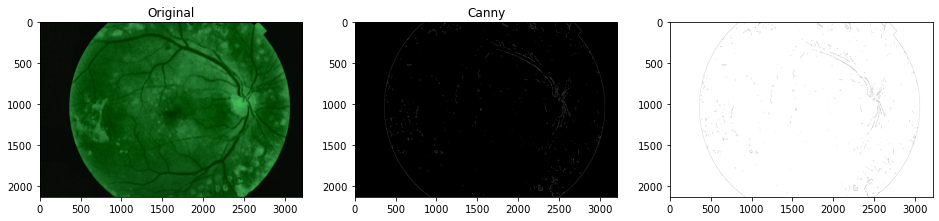

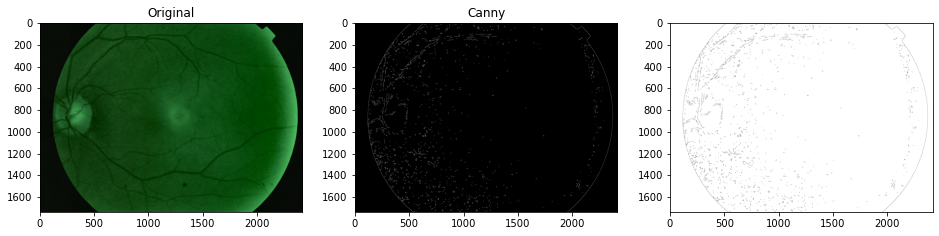

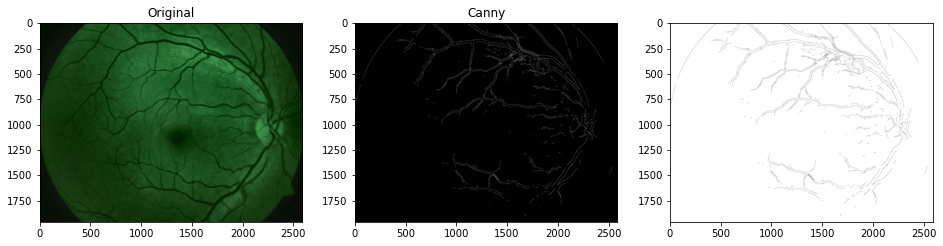

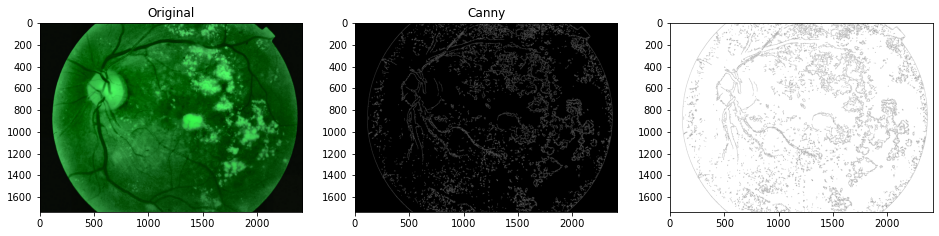

In [ ]:
def canny_edge_detection():
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        
        new_path = os.path.join(path, img_array)
        image = imread(new_path)
        green_channel=deepcopy(image)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        edges = canny(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)/255.)
        img_neg = 1 - edges
        plt.figure(figsize=(16,12))
        plt.subplot(131).imshow(image),plt.title('Original')
        plt.subplot(132).imshow(edges,cmap="gray"),plt.title('Canny')
        plt.subplot(133).imshow(img_neg,cmap="gray")
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        single_dice_coef(img,edges)
        jaccard(img,edges)
canny_edge_detection()        

# KMeansSegmentation

Dice Coeffient 2.8543646129586384
Jaccard 1.0
Dice Coeffient 2.5328220315759102
Jaccard 1.0
Dice Coeffient 2.766517811364816
Jaccard 1.0
Dice Coeffient 2.658600232339116
Jaccard 1.0
Dice Coeffient 1.9942234831864938
Jaccard 1.0


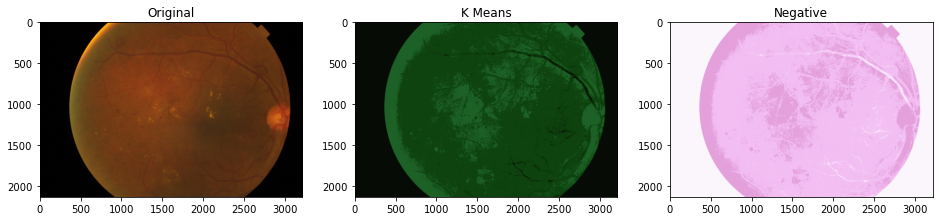

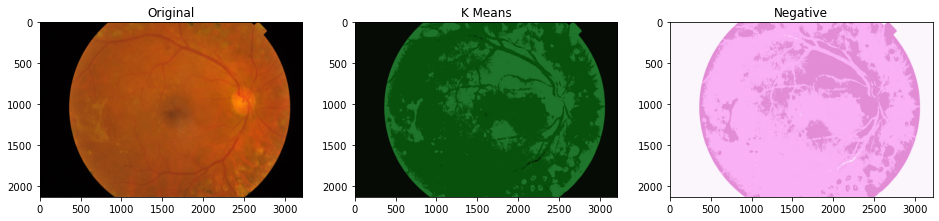

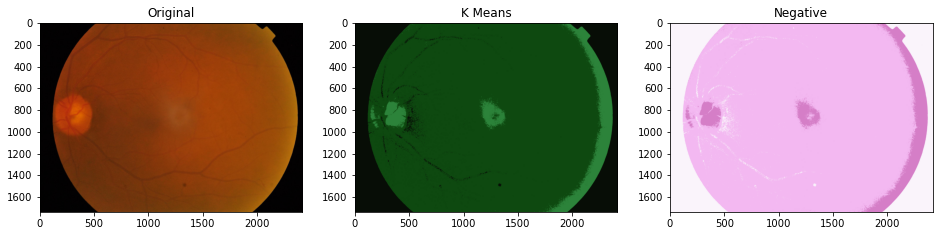

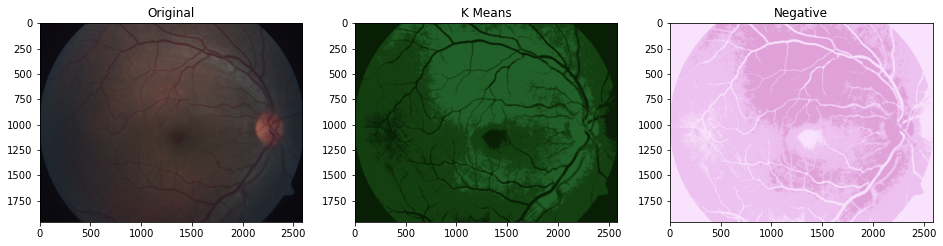

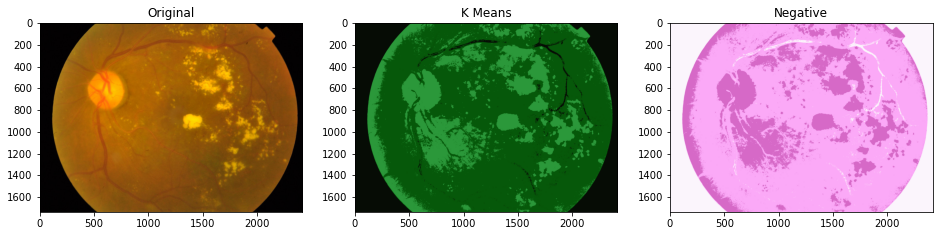

In [ ]:
def KMeansSegmentation(k=3):
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        
        new_path = os.path.join(path, img_array)
        image_original = imread(new_path)
        green_channel=deepcopy(image_original)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)    
        # Reshaping the image into a 2D array of pixels and 3 color values (RGB)
        pixel_vals = image.reshape((-1,3))

        # Convert to float type
        pixel_vals = np.float32(pixel_vals)

        criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.85)

        # then perform k-means clustering wit h number of clusters defined as 3
        #also random centres are initially choosed for k-means clustering
        retval, labels, centers = cv2.kmeans(pixel_vals, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

        # convert data into 8-bit values
        centers = np.uint8(centers)
        segmented_data = centers[labels.flatten()]

        # reshape data into the original image dimensions
        segmented_image = segmented_data.reshape((image.shape))
        img_neg = 1 - segmented_image
        plt.figure(figsize=(16,12))
        plt.subplot(131).imshow(image_original),plt.title('Original')
        plt.subplot(132).imshow(segmented_image),plt.title('K Means')
        plt.subplot(133).imshow(img_neg,cmap="gray"),plt.title('Negative')
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        seg_image=cv2.cvtColor(segmented_image,cv2.COLOR_BGR2GRAY)
        single_dice_coef(img,seg_image)
        jaccard(img,seg_image)
KMeansSegmentation()        

# OTSU

Dice Coeffient 1.2683148180966755
Jaccard 0.6607173635567481
Dice Coeffient 1.1910743581820367
Jaccard 0.7164936087353495
Dice Coeffient 1.291251603932136
Jaccard 0.7937351699118015
Dice Coeffient 1.0375236511718693
Jaccard 0.45149215440794555
Dice Coeffient 0.7254246775465865
Jaccard 0.3391908207953124


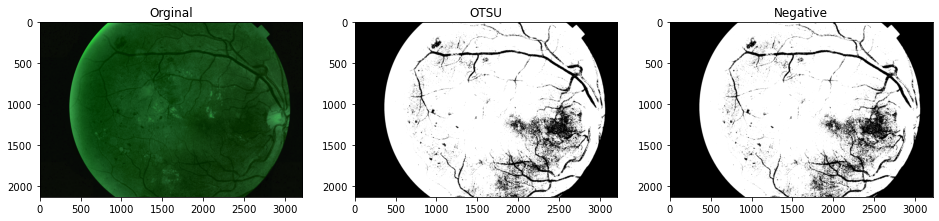

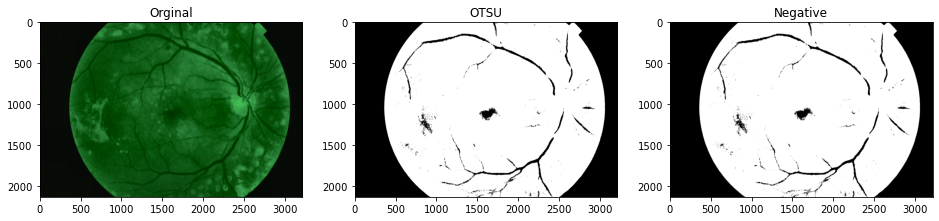

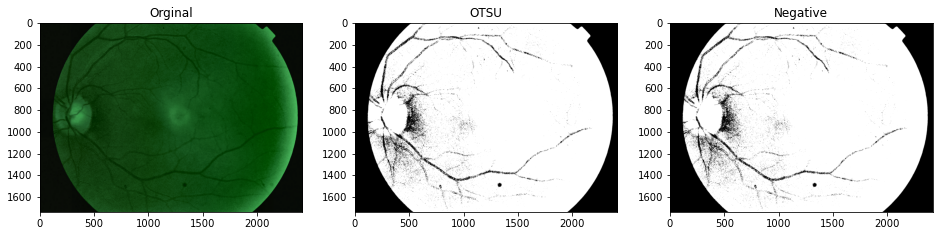

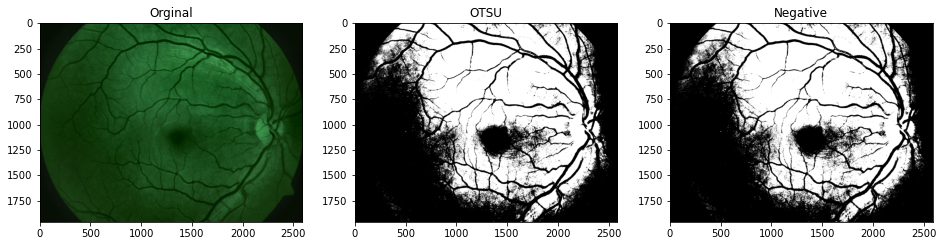

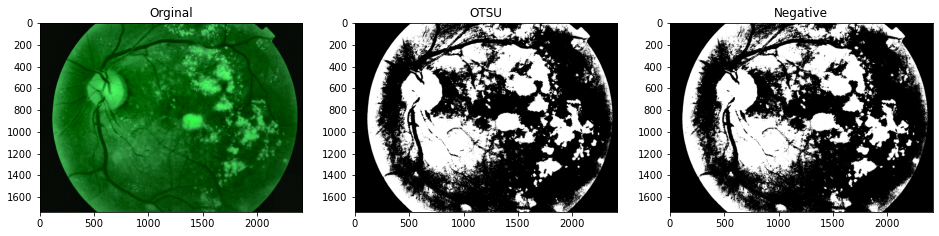

In [ ]:
def otsu():
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        new_path = os.path.join(path, img_array)
        image = imread(new_path)
        green_channel=deepcopy(image)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        # cv2.cvtColor is applied over the
        # image input with applied parameters
        # to convert the image in grayscale
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # applying Otsu thresholding
        # as an extra flag in binary 
        # thresholding     
        ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY + 
                                                    cv2.THRESH_OTSU)     
        img_neg = 1 - thresh1
        # the window showing output image         
        # with the corresponding thresholding         
        # techniques applied to the input image  
        plt.figure(figsize=(16,12))
        plt.subplot(131).imshow(image)
        plt.title("Orginal")
        plt.subplot(132).imshow(thresh1,cmap="gray")     
        plt.title("OTSU")
        plt.subplot(133).imshow(img_neg,cmap="gray"),plt.title('Negative')
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        #seg_image=cv2.cvtColor(segmented_image,cv2.COLOR_BGR2GRAY)
        single_dice_coef(img,thresh1)
        jaccard(img,thresh1)
otsu()        

# THRESHOLD

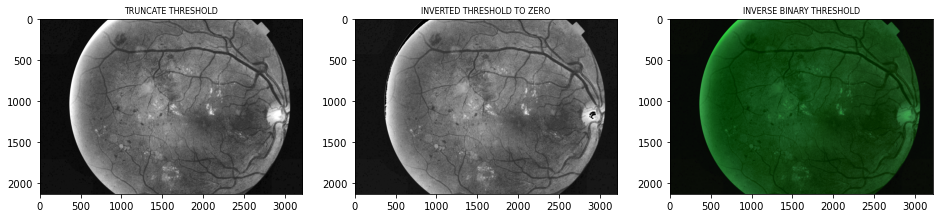

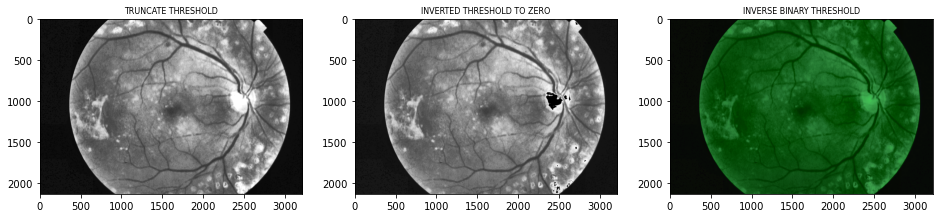

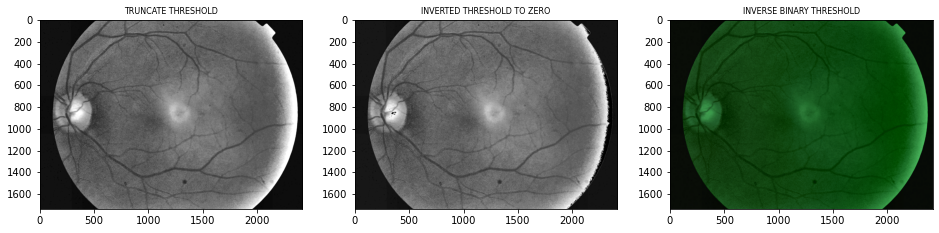

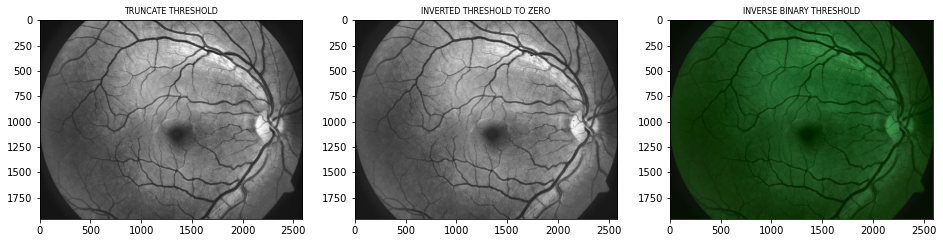

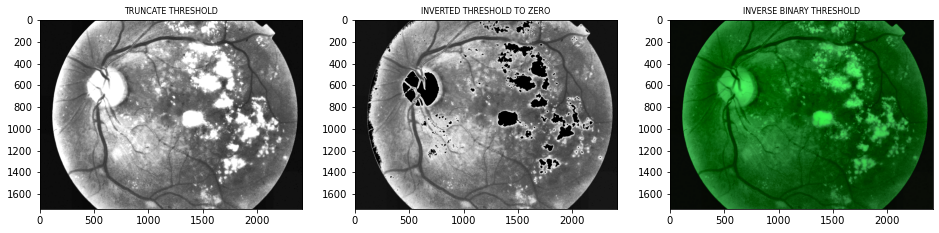

In [ ]:
def threshold():
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        
        new_path = os.path.join(path, img_array)
        image = imread(new_path)
        green_channel=deepcopy(image)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        # cv2.cvtColor is applied over the
        # image input with applied parameters
        # to convert the image in grayscale
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

        # applying different thresholding
        # techniques on the input image
        # all pixels value above 120 will
        # be set to 255
        ret, thresh1 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY)
        ret, thresh2 = cv2.threshold(img, 120, 255, cv2.THRESH_BINARY_INV)
        ret, thresh3 = cv2.threshold(img, 120, 255, cv2.THRESH_TRUNC)
        ret, thresh4 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO)
        ret, thresh5 = cv2.threshold(img, 120, 255, cv2.THRESH_TOZERO_INV)

        # the window showing output images
        # with the corresponding thresholding
        # techniques applied to the input images
        plt.figure(figsize=(16,12))

        #plt.subplot(161).imshow(thresh1,cmap="gray"),plt.title("BINARY THRESHOLD",fontsize = 8)
        #plt.subplot(162).imshow(thresh2,cmap="gray"),plt.title("INVERSE BINARY THRESHOLD",fontsize = 8)
        plt.subplot(131).imshow(thresh3,cmap="gray"),plt.title("TRUNCATE THRESHOLD",fontsize = 8)
        #plt.subplot(164).imshow(thresh4,cmap="gray"),plt.title("THRESHOLD TO ZERO",fontsize =8)
        plt.subplot(132).imshow(thresh5,cmap="gray"),plt.title("INVERTED THRESHOLD TO ZERO",fontsize = 8)
        plt.subplot(133).imshow(image),plt.title("INVERSE BINARY THRESHOLD",fontsize = 8)
threshold()        

# ADAPTIVE THRESHOLD

Dice Coeffient 1.362918119823143
Jaccard 0.7415402796411202
Dice Coeffient 1.2545200039227025
Jaccard 0.7041776429183669
Dice Coeffient 1.293336930087391
Jaccard 0.7328617110965301
Dice Coeffient 1.2769270456688377
Jaccard 0.7753247091550063
Dice Coeffient 1.0131983993178175
Jaccard 0.5677859012115848


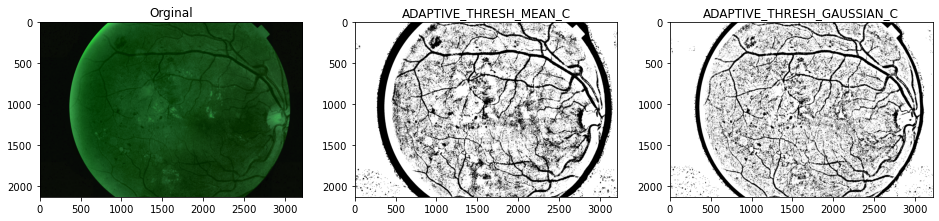

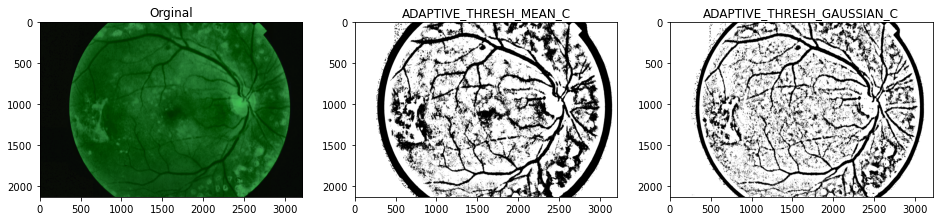

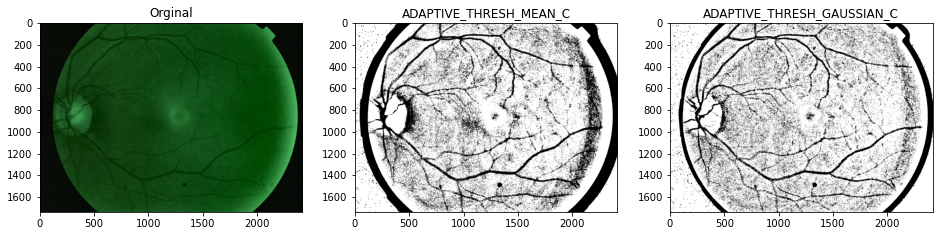

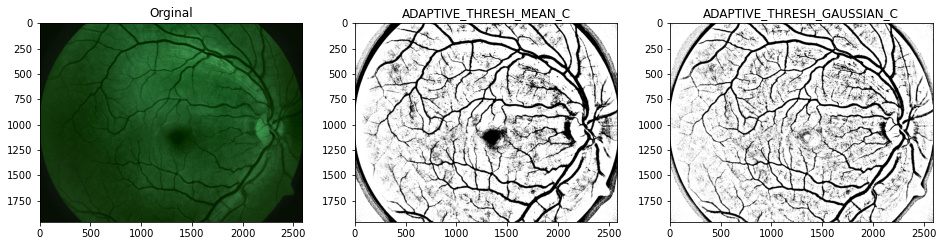

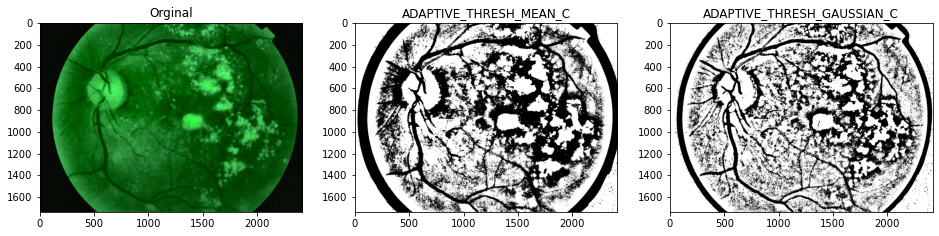

In [ ]:
def adaptive_threshold():
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        
        new_path = os.path.join(path, img_array)
        image = imread(new_path)
        green_channel=deepcopy(image)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        

        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))

        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        # cv2.cvtColor is applied over the
        # image input with applied parameters
        # to convert the image in grayscale
        img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        thresh1 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                          cv2.THRESH_BINARY, 199, 5)
  
        thresh2 = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                          cv2.THRESH_BINARY, 199, 5)
        #img_neg = 1 - thresh1
        #img_neg1 = 1 - thresh2
        # the window showing output image         
        # with the corresponding thresholding         
        # techniques applied to the input image  
        plt.figure(figsize=(16,12))
        plt.subplot(131).imshow(image)
        plt.title("Orginal")
        plt.subplot(132).imshow(thresh1,cmap="gray")     
        plt.title("ADAPTIVE_THRESH_MEAN_C")
        plt.subplot(133).imshow(thresh2,cmap="gray"),plt.title('ADAPTIVE_THRESH_GAUSSIAN_C')
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        #seg_image=cv2.cvtColor(segmented_image,cv2.COLOR_BGR2GRAY)
        single_dice_coef(img,thresh1)
        jaccard(img,thresh1)
adaptive_threshold()        

# GRAPH CUT

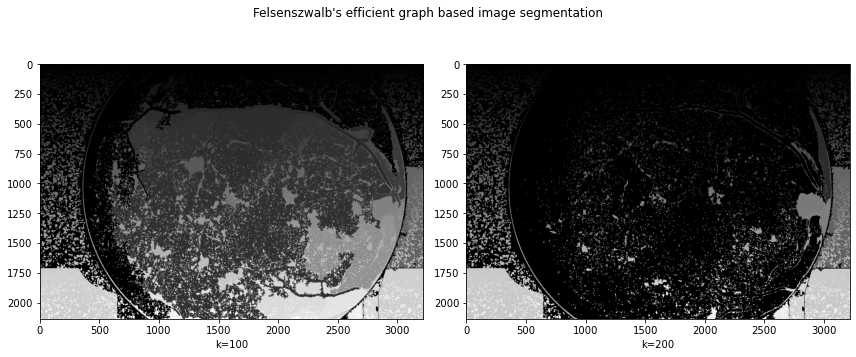

Dice Coeffient 73.32207928753627
Jaccard 0.9824879290346022
Dice Coeffient 43.905168077883694
Jaccard 0.9824876378873423


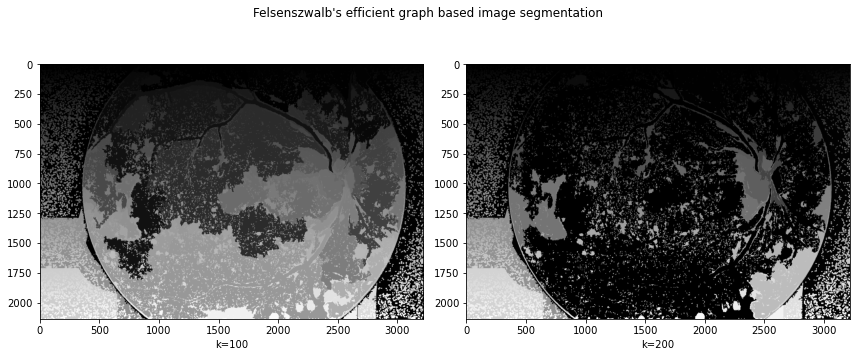

Dice Coeffient 96.97439854237383
Jaccard 0.9578593455941268
Dice Coeffient 80.00404932432292
Jaccard 0.9578284839845715


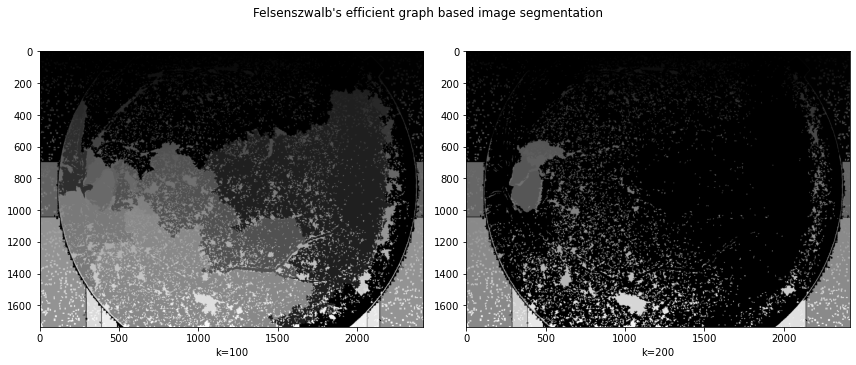

Dice Coeffient 80.15074395790135
Jaccard 0.9677729308450576
Dice Coeffient 57.31514142563464
Jaccard 0.9677729308450576


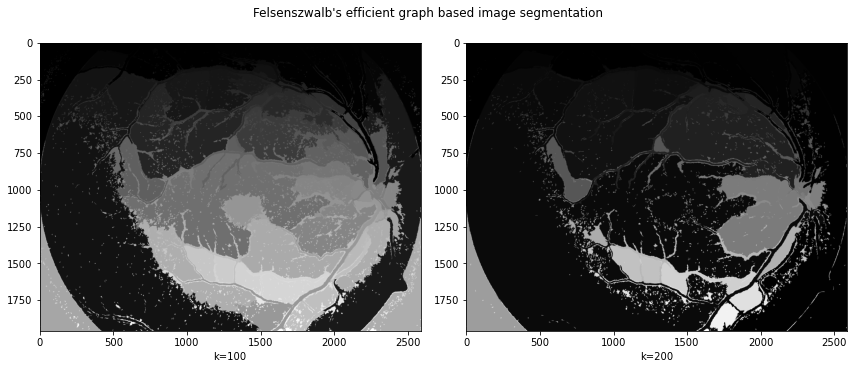

Dice Coeffient 95.28976432835744
Jaccard 0.9923835238619985
Dice Coeffient 87.4911438840448
Jaccard 0.9734673506858874


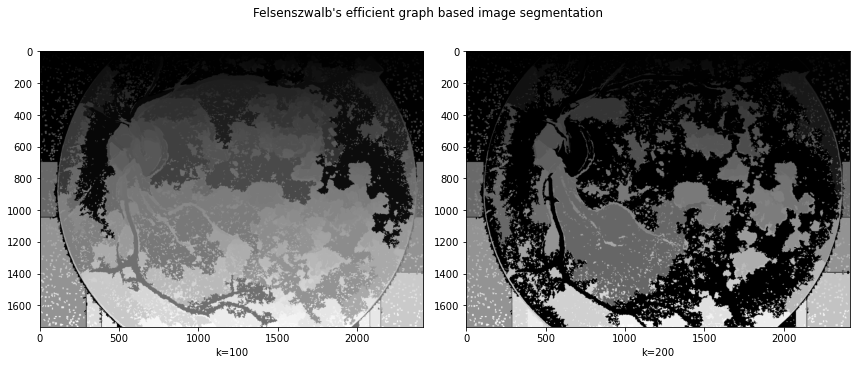

Dice Coeffient 118.69708987857814
Jaccard 0.9682414376506852
Dice Coeffient 116.38450248295227
Jaccard 0.9682414376506852


In [ ]:
import skimage.segmentation
from matplotlib import pyplot as plt

def graph_cut():
    path = "D:/APTOS/SAMPLE"
    for img_array in os.listdir(path):
        
        new_path = os.path.join(path, img_array)
        image = imread(new_path)
        green_channel=deepcopy(image)

        green_channel[:,:,0]=0
        green_channel[:,:,2]=0
        
        lab_img=cv2.cvtColor(green_channel,cv2.COLOR_BGR2LAB)
        l,a,b=cv2.split(lab_img)
        clahe=cv2.createCLAHE(clipLimit=3.0,tileGridSize=(5,5))
        clahe_img=clahe.apply(l)
        
        equ=cv2.equalizeHist(l)
        updated_lab_img1=cv2.merge((equ,a,b))
        hist_eq_img=cv2.cvtColor(updated_lab_img1, cv2.COLOR_LAB2BGR)
        
        updated_lab_img2=cv2.merge((clahe_img,a,b))
        image=cv2.cvtColor(updated_lab_img2,cv2.COLOR_LAB2BGR)
        segment_mask1 = skimage.segmentation.felzenszwalb(image, scale=100)
        segment_mask2 = skimage.segmentation.felzenszwalb(image, scale=200)
        
        fig = plt.figure(figsize=(12, 5))
        ax1 = fig.add_subplot(121)
        ax2 = fig.add_subplot(122)
        ax1.imshow(segment_mask1,cmap='gray'); ax1.set_xlabel("k=100")
        ax2.imshow(segment_mask2,cmap='gray'); ax2.set_xlabel("k=200")
        fig.suptitle("Felsenszwalb's efficient graph based image segmentation")
        plt.tight_layout()
        plt.show()
        
        img=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
        single_dice_coef(img,segment_mask1)
        jaccard(img,segment_mask1)
        single_dice_coef(img,segment_mask2)
        jaccard(img,segment_mask2)
graph_cut()        